Sascha Spors,
Professorship Signal Theory and Digital Signal Processing,
Institute of Communications Engineering (INT),
Faculty of Computer Science and Electrical Engineering (IEF),
University of Rostock,
Germany

# Tutorial Digital Signal Processing

**Uniform Quantization, Dithering, Noiseshaping**,
Winter Semester 2020/21 (Master Course #24505)

- lecture: https://github.com/spatialaudio/digital-signal-processing-lecture
- tutorial: https://github.com/spatialaudio/digital-signal-processing-exercises

Feel free to contact lecturer frank.schultz@uni-rostock.de

# Fundamentals of Quantization

## Packages / Functions

We import the required packages first and put some functions here that we will frequently use.

In [1]:
# most common used packages for DSP, have a look into other scipy submodules
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal

# audio write and play stuff
import soundfile as sf  # requires 'pip install soundfile'
# last tested with soundfile-0.10.3

In [2]:
def my_xcorr2(x, y, scaleopt='none'):
    r""" Cross Correlation function phixy[kappa] -> x[k+kappa] y

    input:
    x   input signal shifted by +kappa
    y   input signal
    scaleopt   scaling of CCF estimator
    output:
    kappa   sample index
    ccf   correlation result
    """
    N = len(x)
    M = len(y)
    kappa = np.arange(0, N+M-1) - (M-1)
    ccf = signal.correlate(x, y, mode='full', method='auto')
    if N == M:
        if scaleopt == 'none' or scaleopt == 'raw':
            ccf /= 1
        elif scaleopt == 'biased' or scaleopt == 'bias':
            ccf /= N
        elif scaleopt == 'unbiased' or scaleopt == 'unbias':
            ccf /= (N - np.abs(kappa))
        elif scaleopt == 'coeff' or scaleopt == 'normalized':
            ccf /= np.sqrt(np.sum(x**2) * np.sum(y**2))
        else:
            print('scaleopt unknown: we leave output unnormalized')
    return kappa, ccf

In [3]:
def uniform_midtread_quantizer(x, deltaQ):
    r"""uniform_midtread_quantizer from the lecture:
    https://github.com/spatialaudio/digital-signal-processing-lecture/blob/master/quantization/linear_uniform_quantization_error.ipynb
    commit: b00e23e
    note: we renamed the second input to deltaQ, since this is what the variable
    actually represents, i.e. the quantization step size

    input:
    x   input signal to be quantized
    deltaQ    quantization step size
    output:
    xq   quantized signal
    """
    # [-1...1) amplitude limiter
    x = np.copy(x)
    idx = np.where(x <= -1)
    x[idx] = -1
    idx = np.where(x > 1 - deltaQ)
    x[idx] = 1 - deltaQ
    # linear uniform quantization
    xq = deltaQ * np.floor(x/deltaQ + 1/2)
    return xq

In [4]:
def my_quant(x, Q):
    r"""Saturated uniform midtread quantizer

    input:
    x  input signal
    Q  number of quantization steps
    output:
    xq quantized signal

    Note: for even Q in order to retain midtread characteristics,
    we must omit one quantization step, either that for lowest or the highest
    amplitudes. Typically the highest signal amplitudes are saturated to
    the 'last' quantization step. Then, in the special case of log2(N)
    being an integer the quantization can be represented with bits.
    """
    tmp = Q//2  # integer div
    quant_steps = (np.arange(Q) - tmp) / tmp  # we don't use this

    # forward quantization, round() and inverse quantization
    xq = np.round(x*tmp) / tmp
    # always saturate to -1
    xq[xq < -1.] = -1.
    # saturate to ((Q-1) - (Q\2)) / (Q\2), note that \ is integer div
    tmp2 = ((Q-1) - tmp) / tmp  # for odd N this always yields 1
    xq[xq > tmp2] = tmp2
    return xq

## Quantization Process and Error

Quantization generates signals that have discrete values $x_q[k]$, $x_q(t)$ from signals with continuous values $x[k]$, $x(t)$. 

For quantization, the signals can be both, discrete and continuous in time.
However, a signal that is discrete in time **and** discrete in value is termed a **digital** signal.
Only digital signals can be processed by computers.
Here the quantization of discrete-time signals is treated due to practical importance.

To describe quantization analytically, the model in the figure below is used.

<img src="QuantizationModel.png" alt="QuantizationModel.png" width="400"/>

The input and output signal differ by the so called quantization error (quantization noise) $e[k]$, that is defined as

\begin{equation}
e[k] = x_q[k] - x[k],
\end{equation}

so that the error constitutes an additive superposition

\begin{equation}
x[k] + e[k] = x_q[k]
\end{equation}


To use this error model, some assumption have to be made.
The quantization noise shall be uniformly distributed, which then can be modeled with the probability density function (PDF) $p_e(\theta) = \frac{1}{\Delta Q} \mathrm{rect}(\frac{\theta_e}{\Delta Q})$, where $\Delta Q$ denotes the quantization step size and $\theta_e$ the amplitudes of the quantization error signal.
This PDF is shown below.

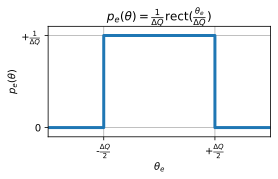

In [5]:
plt.figure(figsize=(4, 2))
plt.plot((-1, -1/2, -1/2, +1/2, +1/2, +1), (0, 0, 1, 1, 0, 0), lw=3)
plt.xlim(-1, 1)
plt.ylim(-0.1, 1.1)
plt.xticks((-0.5, +0.5), [r'-$\frac{\Delta Q}{2}$', r'+$\frac{\Delta Q}{2}$'])
plt.yticks((0, 1), [r'0', r'+$\frac{1}{\Delta Q}$'])
plt.xlabel(r'$\theta_e$')
plt.ylabel(r'$p_e(\theta)$')
plt.title(
    r'$p_e(\theta) = \frac{1}{\Delta Q} \mathrm{rect}(\frac{\theta_e}{\Delta Q})$')
plt.grid(True)

Furthermore, it is assumed that $e[k]$ is not correlated with $x[k]$.
That this is not necessarily the case can be demonstrated with the help of some straightforward examples.

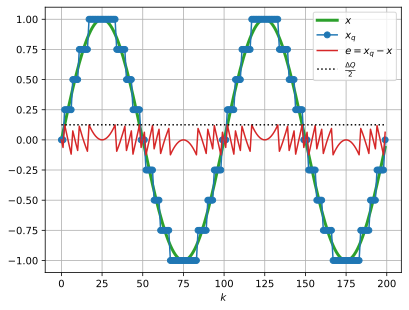

In [6]:
Q = 9  # odd, number of quantization steps
N = 100
k = np.arange(2*N)
x = np.sin(2*np.pi/N*k)
xq = my_quant(x, Q)
e = xq-x
# actually stem plots would be correct, for convenience we plot as line style
plt.plot(k, x, 'C2', lw=3, label=r'$x$')
plt.plot(k, xq, 'C0o-', label=r'$x_q$')
plt.plot(k, e, 'C3', label=r'$e=x_q-x$')
plt.plot(k, k*0+1/(Q-1), 'k:', label=r'$\frac{\Delta Q}{2}$')
plt.xlabel(r'$k$')
plt.legend()
plt.grid(True)

A sine signal is quantized with $Q=9$ quantization steps.
A periodicity of the quantization noise can be easily identified.
For odd $Q$, the maximum amplitude of the quantization error can be estimated to

$$\frac{\Delta Q}{2}=\frac{\frac{2}{Q-1}}{2}=\frac{1}{Q-1}=\frac{1}{8}=0.125.$$

The auto-correlation function of the error signal $e[k]$ is presented next.

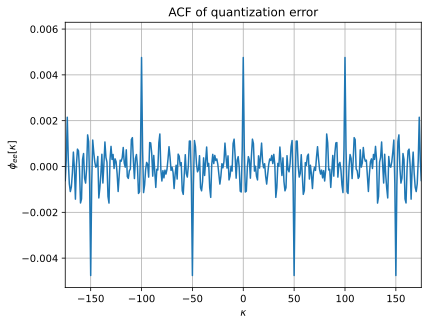

In [7]:
kappa, acf = my_xcorr2(e, e, 'unbiased')
plt.plot(kappa, acf)
plt.xlim(-175, +175)
plt.xlabel(r'$\kappa$')
plt.ylabel(r'$\phi_{ee}[\kappa]$')
plt.title('ACF of quantization error')
plt.grid(True)

If $e[k]$ would be exactly following the probability density function $p_e(\theta) = \frac{1}{\Delta Q} \mathrm{rect}(\frac{\theta_e}{\Delta Q})$, the auto-correlation function $\phi_{ee}[\kappa]=\delta[\kappa]$ results.

However, this is not observable in this example!

Instead, from the above plot, we can deduce that $e[k]$ is correlated to itself, i.e. it exhibits periodicity each 100 samples in phase, and each 50 sample out of phase.
The sine period is precisely 100 samples, thus the input signal and the quantization error are somewhat linked and not independent.
Thus, the error model assumption is violated. That is bad, since the sine signal allows for otherwise comparable simple analytical calculus.

The links between the signals can be furthermore confirmed with the help of the cross-correlation functions.
Their oscillating characteristics reveal that quantization error is highly correlated. 

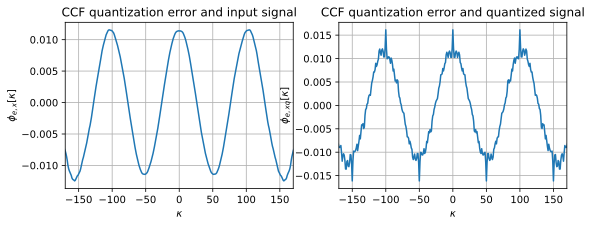

In [8]:
plt.figure(figsize=(9, 3))

plt.subplot(1, 2, 1)
kappa, acf = my_xcorr2(e, x, 'unbiased')
plt.plot(kappa, acf)
plt.xlim(-170, +170)
plt.xlabel(r'$\kappa$')
plt.ylabel(r'$\phi_{e,x}[\kappa]$')
plt.title('CCF quantization error and input signal')
plt.grid(True)

plt.subplot(1, 2, 2)
kappa, acf = my_xcorr2(e, xq, 'unbiased')
plt.plot(kappa, acf)
plt.xlim(-170, +170)
plt.xlabel(r'$\kappa$')
plt.ylabel(r'$\phi_{e,xq}[\kappa]$')
plt.title('CCF quantization error and quantized signal')
plt.grid(True)

Therefore, the special case of sine signals is in fact not suited for the quantization model above.
Because of the simplicity of the involved calculation it is common practice to conduct this analysis for sine signals nevertheless, and signal-to-noise ratios in the data sheets of A/D converters are mostly stated for excitation with sine signals.
For random signals, the quantization model is only valid for high levels in the quantizer. For more information see
[Udo Zölzer, Digital Audio Signal Processing, Wiley](https://onlinelibrary.wiley.com/doi/book/10.1002/9780470680018)
(might be available as free access in your uni network)

-  Task:
Increase the (odd) number of quantization steps $Q$ and check what happens with the shape and amplitudes of the correlations functions. Hint: closer look to the amplitudes of the correlation signals.

## Quantization Modeling / Mapping

The mapping of the infinitely large continuous set of values to a discrete number of amplitude steps is realized with a transfer characteristic.
The height of the amplitude steps is $\Delta Q$.



From the lecture, we know that the following mapping is used in order to quantize the continuous amplitude signal $x[k]$

towards

\begin{equation}
x_Q[k] = g( \; \lfloor \, f(x[k]) \, \rfloor \; ),
\end{equation}

where $g(\cdot)$ and $f(\cdot)$ denote real-valued mapping functions, and $\lfloor \cdot \rfloor$ a rounding operation (**not necessarily the plain floor operation**).

### Uniform Saturated Midtread Quantization Characteristic Curve

With the introduced mapping, the uniform saturated midtread quantizer can be discussed.
This is probably the most important curve for uniform quantization due to its practical relevance for coding quantized amplitude values as bits. In general, the uniform midtread quantizer can be given as the mapping

\begin{equation}
x_Q[k] =  \frac{1}{Q \backslash 2} \cdot \lfloor (Q \backslash 2) \cdot x[k]\rfloor,
\end{equation}

where for $\lfloor \cdot \rfloor$ a rounding operation might used and $\backslash$ denotes integer division.
So the mapping functions $g$ and $f$ are simple multiplications.
At the beginning of this notebook, the function `my_quant` is implemented that realizes quantization based on this mapping.
The approach uses `numpy`'s `round` operation.
When asking for rounding, care has to be taken, which [approach](https://en.wikipedia.org/wiki/Rounding) shall be used.
Numpy rounds to the nearest **even** integer in contrast to e.g. Matlab's rounding to nearest integer.

Detailed analysis for `my_quant`:

- the quantization should be properly performed only for $-1 \leq x < 1$
- thus, it always saturates $x<-1$ towards $x_q = -1$
- in the case of an **odd** number of quantization steps $Q$, it saturates $x>+1$ towards $x_q = +1$. The quantization step size is $\Delta Q = \frac{2}{Q-1}$.
- In the case of an **even** number of quantization steps $Q$, it saturates $x>\frac{Q - 1 - \frac{Q}{2}}{\frac{Q}{2}} = 1-\frac{2}{Q}$ towards $x_q = \frac{Q - 1 - \frac{Q}{2}}{\frac{Q}{2}}=1-\frac{2}{Q}$. The quantization step size is $\Delta Q = \frac{2}{Q}$.

### AD / DA Converter Convention

The case of **even** $Q$ is practically used for virtually all analog/digital (AD) and digital/analog (DA) converters.

When additionally to the above statements

\begin{equation}
\log_2(Q)\in\mathbb{N}
\end{equation}

holds, it is meaningful to code the even and power of two $Q$ possible quantization steps with bits.

With $B\in\mathbb{N}$ denoting the number of bits, the number range convention for AD and DA converters is 

\begin{equation}
\begin{split}
&-1\leq x \leq 1-2^{-(B-1)}\\
&-1\leq x \leq 1-\frac{2}{Q}
\end{split}
\end{equation}

using 

\begin{equation}
Q=2^B
\end{equation}

quantization steps.
Values of $x$ outside this range will be saturated to the minimum $-1$ and maximum $1-\frac{2}{Q}$ quantization values in the quantization process.

For example, $B = 16$ bits are used to code [PCM data for CD](https://en.wikipedia.org/wiki/Compact_disc) audio quality.
Then we get the following quantities.

In [9]:
B = 16  # number of bits
Q = 2**B  # number of quantization steps

# for even Q only:
deltaQ = 2/Q
# maximum quantize value:
xqmax = 1-2**(-(B-1))
# or more general for even Q:
xqmax = 1-deltaQ

print(' B = %d bits\n quantization steps Q = %d\n quantization step size %e' %
      (B, Q, deltaQ))
print(' smallest quantization value xqmin = -1')
print(' largest quantization value xqmax = %16.15f' % xqmax)
# B = 16 bits
# quantization steps Q = 65536
# quantization step size 3.051758e-05
# smallest quantization value xqmin = -1
# largest quantization value xqmax = 0.999969482421875

 B = 16 bits
 quantization steps Q = 65536
 quantization step size 3.051758e-05
 smallest quantization value xqmin = -1
 largest quantization value xqmax = 0.999969482421875


So called high definition audio uses 24 Bit. Video and photo typically uses 8-12 Bit quantization per color channel.

### Plotting the Midtread Curve

We now can visualize the characteristic curve for a simple, made up input signal, i.e. a monotonic increasing signal between $x_{max} = -x_{min}$ using an equidistant increment $\Delta x$ over sample index $k$.

Here, we use $x_{max} = 1.25$ and $\Delta x=0.001$ and assume that we start with $x_{min} = -1.25$ at $k=0$.
If $\Delta x$ is sufficiently small, the signal's amplitude can be interpreted as continuous straight line.
This straight line is degraded in a quantization process.
Plotting the quantization result over the input, results in the characteristic curve, in our example in the curve of the uniform saturated midtread quantizer.

Let us plot this.

**Please note:**
The quantizer `uniform_midtread_quantizer` known from lecture and `my_quant` yield the same results besides a slight detail: `uniform_midtread_quantizer` always exhibits an **even** number of quantization steps $Q$.
So, only for even $Q$ results are exactly identical.

We might verify this in the next plots as well.

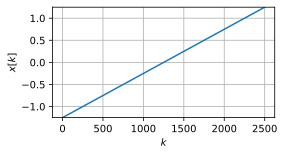

In [10]:
x = np.arange(-1.25, +1.25, 1e-3)
plt.figure(figsize=(4, 2))
plt.plot(x)  # actually a stem plot is correct
plt.ylim(-1.25, +1.25)
plt.xlabel(r'$k$')
plt.ylabel(r'$x[k]$')
plt.grid(True)

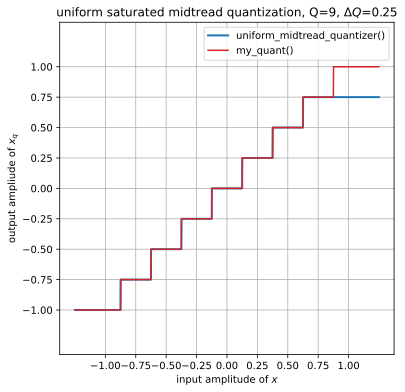

In [11]:
Q = 9  # number of quantization steps, odd or even
deltaQ = 1/(Q//2)  # quantization step size, even/odd Q

xq = my_quant(x, Q)  # used in exercise
xumq = uniform_midtread_quantizer(x, deltaQ)  # as used in lecture

plt.figure(figsize=(6, 6))
plt.plot(x, xumq, 'C0', lw=2, label='uniform_midtread_quantizer()')
plt.plot(x, xq, 'C3', label='my_quant()')
plt.xticks(np.arange(-1, 1.25, 0.25))
plt.yticks(np.arange(-1, 1.25, 0.25))
plt.xlabel(r'input amplitude of $x$')
plt.ylabel(r'output ampliude of $x_q$')
plt.title(
    r'uniform saturated midtread quantization, Q={0:d}, $\Delta Q$={1:3.2f}'.format(Q, deltaQ))
plt.axis('equal')
plt.legend()
plt.grid(True)

The following exercises used to be a homework assignment as exam's prerequisite.

# Exercise 1: Uniform Saturated Midtread Characteristic Curve of Quantization

## Task

Check this quantizer curve for $Q=7$ and $Q=8$.
Make sure that you get the idea of the midtread concept (the zero is always quantized to zero) and saturation (for even $Q$) largest quantization step is saturated).

In [12]:
def check_my_quant(Q):
    N = 5e2
    x = 2*np.arange(N)/N - 1
    xq = my_quant(x, Q)
    e = xq - x

    plt.plot(x, x, color='C2', lw=3, label=r'$x[k]$')
    plt.plot(x, xq, color='C3', label=r'$x_q[k]$')
    plt.plot(x, e, color='C0', label=r'$e[k] = x_q[k] - x[k]$')
    plt.xticks(np.arange(-1, 1.25, 0.25))
    plt.yticks(np.arange(-1, 1.25, 0.25))
    plt.xlabel('input amplitude')
    plt.ylabel('output amplitude')
    if np.mod(Q, 2) == 0:
        s = ' saturated '
    else:
        s = ' '
    plt.title(
        'uniform'+s+'midtread quantization with Q=%d steps, $\Delta Q$=%4.3e' % (Q, 1/(Q//2)))
    plt.axis('equal')
    plt.legend(loc='upper left')
    plt.grid(True)

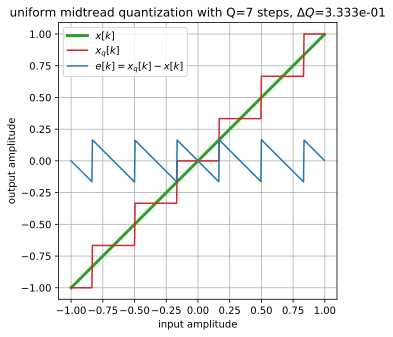

In [13]:
Q = 7  # number of quantization steps
deltaQ = 1 / (Q//2)  # general rule
deltaQ = 2 / (Q-1)  # for odd Q only
plt.figure(figsize=(5, 5))
check_my_quant(Q)

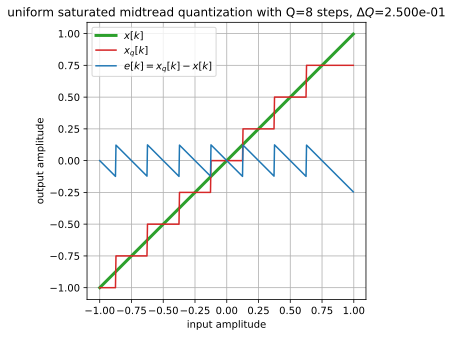

In [14]:
Q = 8  # number of quantization steps
deltaQ = 1 / (Q//2)  # general rule
deltaQ = 2 / Q  # for even Q only
plt.figure(figsize=(5, 5))
check_my_quant(Q)

# Exercise 2: Quantization and Signal-to-Noise Ratio

From theory the **6dB / Bit rule of thumb** is well known for uniform quantization. It states that the signal-to-noise ratio increases by 6 dB for every additional bit that is spent to quantize the input data.
Hence,

\begin{equation}
\text{SNR in dB} = 6 \cdot B + \gamma,
\end{equation}

where $\gamma$ is a offset value in dB that depends on the PDF of the signal to be quantized.
Note that this rule of thumb assumes that the quantization error exhibits uniform PDF and is not correlated with the quantized signal.
We can see that this rule of thumb is inaccurate when quantizing a sine signal with small number of bits or an amplitude in the range of the quantization step. Then, the mentioned assumptions are not fulfilled. We will observe this in exercise 3.

We plot the function SNR of bits below for uniform, normal and Laplace PDF noises and a sine signal.
We should observe the slope of always 6 dB per Bit.
We should note the different absolute values of the SNR depending on the varying $\gamma$. 

The `dBoffset` values are discussed in the lecture and in the textbook [Udo Zölzer, Digital Audio Signal Processing, Wiley](https://onlinelibrary.wiley.com/doi/book/10.1002/9780470680018).

In [15]:
def check_quant_SNR(x, dBoffset, title):
    print('std: {0:f}, var: {1:f}, mean: {2:f} of x'.format(np.std(x), np.var(x), np.mean(x)))
    Bmax = 24
    SNR = np.zeros(Bmax+1)
    SNR_ideal = np.zeros(Bmax+1)

    for B in range(1, Bmax+1):  # start at 1, since zero Q is not meaningful
        xq = my_quant(x, 2**B)
        SNR[B] = 10*np.log10(np.var(x) / np.var(xq-x))
        SNR_ideal[B] = B*20*np.log10(2) + dBoffset  # 6dB/bit + offset rule

    plt.figure(figsize=(5, 5))
    plt.plot(SNR_ideal, 'o-', label='theoretical', lw=3)
    plt.plot(SNR, 'x-', label='simulation')
    plt.xticks(np.arange(0, 26, 2))
    plt.yticks(np.arange(0, 156, 12))
    plt.xlim(2, 24)
    plt.ylim(6, 148)
    plt.xlabel('number of bits')
    plt.ylabel('SNR / dB')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    print('maximum achievable SNR = {0:4.1f} dB at 24 Bit (i.e. HD audio)'.format(SNR[-1]))    

In [16]:
N = 10000
k = np.arange(N)

std: 0.577350, var: 0.333333, mean: -0.000000 of x
maximum achievable SNR = 144.5 dB at 24 Bit (i.e. HD audio)


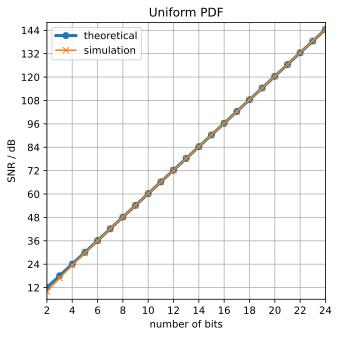

In [17]:
np.random.seed(4)
x = np.random.rand(N)
x -= np.mean(x)
x *= np.sqrt(1/3) / np.std(x)
dBoffset = 0
check_quant_SNR(x, dBoffset, 'Uniform PDF')

std: 0.706997, var: 0.499845, mean: 0.000058 of x
maximum achievable SNR = 146.3 dB at 24 Bit (i.e. HD audio)


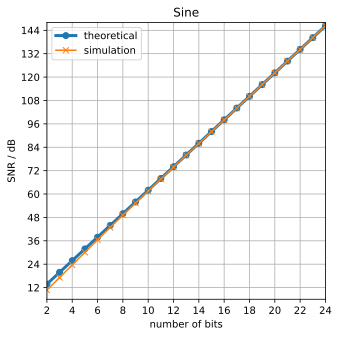

In [18]:
Omega = 2*np.pi * 997/44100  # use a rather odd ratio: e.g. in audio 997 Hz / 44100 Hz
sigma2 = 1/2
dBoffset = -10*np.log10(2 / 3)
x = np.sqrt(2*sigma2) * np.sin(Omega*k)
check_quant_SNR(x, dBoffset, 'Sine')

std: 0.217025, var: 0.047100, mean: -0.000000 of x
maximum achievable SNR = 135.9 dB at 24 Bit (i.e. HD audio)


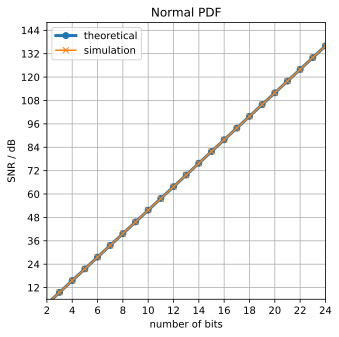

In [19]:
np.random.seed(4)
x = np.random.randn(N)
x -= np.mean(x)
x *= np.sqrt(0.0471) / np.std(x)
dBoffset = -8.5  # from clipping propability 1e-5
check_quant_SNR(x, dBoffset, 'Normal PDF')

std: 0.122837, var: 0.015089, mean: 0.000000 of x
maximum achievable SNR = 131.1 dB at 24 Bit (i.e. HD audio)


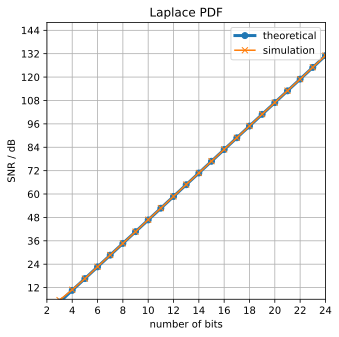

In [20]:
np.random.seed(4)
x = np.random.laplace(size=N)
pClip = 1e-5  # clipping propability
sigma = -np.sqrt(2) / np.log(pClip)
x -= np.mean(x)
x *= sigma / np.std(x)
dBoffset = -13.5  # empircially found for pClip = 1e-5
check_quant_SNR(x, dBoffset, 'Laplace PDF')

# Exercise 3: Dithering

The discrete-time sine signal

- $x[k]=A \cdot\sin(\frac{2\pi f_\text{sin}}{f_s}k)$ for
- $0\leq k<96000$ with
- sampling frequency $f_s=48\,\text{kHz}$ and
- $f_\text{sin}=997\,\text{Hz}$

shall be quantized with the saturated uniform midtread quantizer for $-1\leq x_q \leq 1-\Delta Q$ using $B$ bits, i.e. $Q=2^B$ number of quantization steps and quantization step size of $\Delta Q = \frac{1}{Q\backslash 2}$.

We should discuss different parametrizations for signal amplitude $A$ and number of bits $B$.

Before quantizing $x[k]$, a dither noise signal $d[k]$ shall be added to $x[k]$ according figure below. 

<img src="Quantization_with_Dithering.png" alt="Quantization_with_Dithering" width="400"/>

This dither signal with small amplitudes aims at de-correlating the quantization error $e[k]$ from the quantized signal $x_q[k]$, which is especially important for small amplitudes of $x[k]$.
This technique is called **dithering**.
For $d[k]=0$ no dithering is applied.

Since the quantization error may be in the range $-\frac{\Delta Q}{2}\leq e[k]\leq \frac{\Delta Q}{2}$ (assuming uniform distribution), it appears reasonable to use a dither noise with a probability density function (PDF) of

\begin{equation}
p_\text{RECT}(d)=\frac{1}{\Delta Q}\,\text{rect}\left(\frac{d}{\Delta Q}\right),
\end{equation}

i.e. a **zero-mean, uniformly distributed noise** with maximum amplitude $|d[k]|=\frac{\Delta Q}{2}$.
It can be shown that this dither noise improves the quality of the quantized signal.
However, there is still a noise modulation (i.e. a too high correlation between $x_q[k]$ and $e[k]$) that depends on the amplitude of the input signal.

The noise modulation can be almost completely eliminated with a **zero-mean noise** signal exhibiting a **symmetric triangular PDF**

\begin{equation}
p_\text{TRI}(d)=\frac{1}{\Delta Q}\,\text{tri}\left(\frac{d}{\Delta Q}\right)
\end{equation}

with maximum amplitude $|d[k]|=Q$.
By doing so, an almost ideal decorrelation between $x_q[k]$ and $e[k]$ is realized.
In audio, this technique is called TPDF-Dithering (Triangular Probability Density Function Dithering) and can be applied in the mastering process of audio material that is to be distributed e.g. on a CD or via streaming.

## Task 

To get an impression on how dithering may be implemented and what quantized signals sound like, the following exercises shall be performed.

- Generate the sine signal $x[k]$ defined above.

- Generate the dither noise $d_\text{RECT}[k]$ according to the PDF $p_\text{RECT}(d)$. Check the resulting amplitude and distribution carefully. The length of $d_\text{RECT}[k]$ and $x[k]$ must be equal.

- Generate the dither noise $d_\text{TRI}[k]$ according to the PDF $p_\text{TRI}(d)$. Check the resulting amplitude and distribution carefully. The length of $d_\text{TRI}[k]$ and $x[k]$ must be equal.

- Add each dither noise $d_\text{RECT}[k]$ and $d_\text{TRI}[k]$ individually to $x[k]$. Together with the case of no dithering we now have three signals to be quantized.

- Quantize these signals individually using `my_quant(x,Q)` with $Q$ quantization steps.

- Plot the midtread characteristic curve.

- Plot the histogram of the dither noises as estimate of its PDF.

- Plot the histogram of the error noises as estimate of its PDF.

- Plot the sine signal, the dithered signal, the quantized signal and the quantization error signal in one diagram for all three cases.

- Calculate and plot the CCF of the signals $x_q[k]$ and $e[k]$ for all three cases.

- Interpret the obtained graphics.

- For each case, render WAV files from $x[k]$, $x[k]+d[k]$, $x_q[k]$ und $e[k]$ and listen to them. **Be careful! Do not harm your ears!** Pay special attention to the sound of the quantization error, how it is correlated with the quantized signal and how loud it appears.

- Consider the 5 cases

    1. $B=16$ Bit, $A=1-\Delta Q$ 
    2. $B=16$ Bit, $A=\Delta Q$
    3. $B=3$ Bit, $A=1-\Delta Q$ 
    4. $B=3$ Bit, $A=\Delta Q$
    5. $B=3$ Bit, $A=\frac{\Delta Q}{2}$

In the last case the signal has amplitude even below the quantization step size $\Delta Q$. You might verify by listening that the sine is still perceivable if dithering is applied, but not if no dithering is applied.

**Again: Be careful! Do not harm your ears!**
The signal amplitude $A$ and chosen $B$ is directly related to the playback level!

**Warning again: start with very very low playback level, find the loudest signal first and then increase volume to your convenience**

## Solution

The task asks for repeated steps.
This is perfectly handled by a little function that solves the repeating subtasks.

In [21]:
fs = 48000
N = 2*fs
k = np.arange(0, N)
fsin = 997

In [22]:
def check_dithering(x, dither, Q, case):

    deltaQ = 1 / (Q//2)  # general rule

    # dither noise
    pdf_dither, edges_dither = np.histogram(dither, bins='auto', density=True)
    xd = x + dither

    # quantization
    xq = my_quant(xd, Q)
    e = xq-x
    pdf_error, edges_error = np.histogram(e, bins='auto', density=True)

    # write wavs
    sf.write(file='x_'+case+'.wav', data=x,
             samplerate=48000, subtype='PCM_24')
    sf.write(file='xd_'+case+'.wav', data=xd,
             samplerate=48000, subtype='PCM_24')
    sf.write(file='xq_'+case+'.wav', data=xq,
             samplerate=48000, subtype='PCM_24')
    sf.write(file='e_'+case+'.wav', data=e,
             samplerate=48000, subtype='PCM_24')

    # CCF
    kappa, ccf = my_xcorr2(xq, e, scaleopt='biased')

    plt.figure(figsize=(12, 3))
    if case == 'nodither':
        plt.subplot(1, 2, 1)
        # nothing to plot for the zero signal
        # the PDF would be a weighted Dirac at amplitude zero
    else:
        # plot dither noise PDF estimate as histogram
        plt.subplot(1, 2, 1)
        plt.plot(edges_dither[:-1], pdf_dither, 'o-', ms=5)
        plt.ylim(-0.1, np.max(pdf_dither)*1.1)
        plt.grid(True)
        plt.xlabel(r'$\theta$')
        plt.ylabel(r'$\hat{p}(\theta)$')
        plt.title('PDF estimate of dither noise')

    # plot error noise PDF estimate as histogram
    plt.subplot(1, 2, 2)
    plt.plot(edges_error[:-1], pdf_error, 'o-', ms=5)
    plt.ylim(-0.1, np.max(pdf_error)*1.1)
    plt.grid(True)
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$\hat{p}(\theta)$')
    plt.title('PDF estimate of error noise')

    # plot signals
    plt.figure(figsize=(12, 3))
    plt.subplot(1, 2, 1)
    plt.plot(k, x, color='C2', label=r'$x[k]$')
    plt.plot(k, xd,  color='C1', label=r'$x_d[k] = x[k] + dither[k]$')
    plt.plot(k, xq,  color='C3', label=r'$x_q[k]$')
    plt.plot(k, e,  color='C0', label=r'$e[k] = x_q[k] - x[k]$')
    plt.plot(k, k*0+deltaQ, ':k', label=r'$\Delta Q$')
    plt.xlabel('k')
    plt.title('signals')
    plt.xticks(np.arange(0, 175, 25))
    plt.xlim(0, 150)
    plt.legend(loc='lower left')
    plt.grid(True)

    # plot CCF
    plt.subplot(1, 2, 2)
    plt.plot(kappa, ccf)
    plt.xlabel(r'$\kappa$')
    plt.ylabel(r'$\varphi_{xq,e}[\kappa]$')
    plt.title('CCF betwen xq and e=xq-x')
    plt.xticks(np.arange(-100, 125, 25))
    plt.xlim(-100, 100)
    plt.grid(True)

Chose one of the 5 cases and evaluate no dither, uniform PDF dither and triangular PDF dither noises below.  

In [23]:
# case 1
B = 16  # Bit
Q = 2**B  # number of quantization steps
deltaQ = 1 / (Q//2)  # quantization step size
x = (1-deltaQ) * np.sin(2*np.pi*fsin/fs*k)  # largest positive amplitude

In [24]:
# case 2
B = 16
Q = 2**B
deltaQ = 1 / (Q//2)
x = deltaQ * np.sin(2*np.pi*fsin/fs*k)  # smallest amplitude

In [25]:
# case 3
B = 3
Q = 2**B
deltaQ = 1 / (Q//2)
x = (1-deltaQ) * np.sin(2*np.pi*fsin/fs*k)

In [26]:
# case 4  this is the default case when running the whole notebook
B = 3
Q = 2**B
deltaQ = 1 / (Q//2)
x = deltaQ * np.sin(2*np.pi*fsin/fs*k)

In [27]:
# case 5
if False:
    B = 3
    Q = 2**B
    deltaQ = 1 / (Q//2)
    # amplitude below quantization step!
    x = deltaQ/2 * np.sin(2*np.pi*fsin/fs*k)

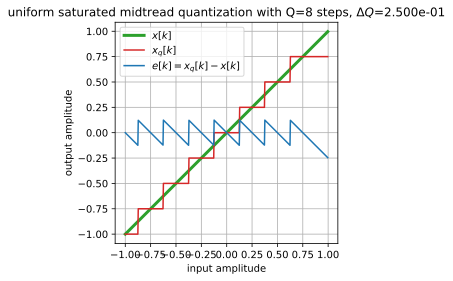

In [28]:
plt.figure(figsize=(4, 4))
check_my_quant(Q)

### No Dither Noise

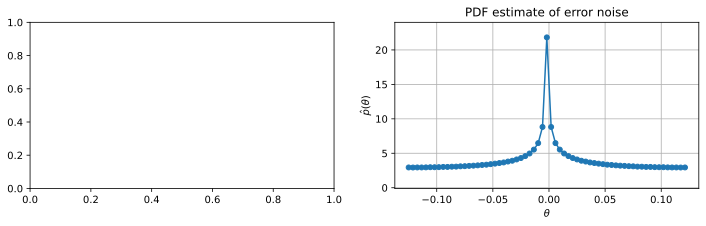

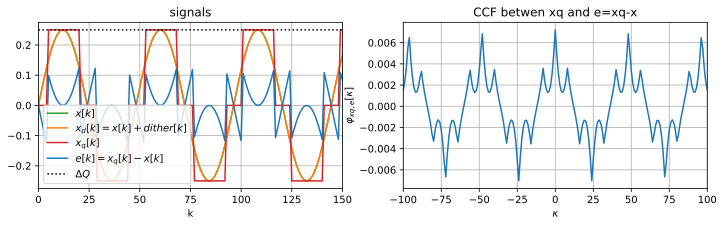

In [29]:
# no dither
check_dithering(x=x, dither=x*0, Q=Q, case='nodither')

**Be careful! Do not harm your ears!**

| Signal            | Audio Player  |
| ----------------- | :------------ |
| $x[k]$            | <audio type="audio/wave" src="x_nodither.wav" controls></audio> |
| $x_q[k]$          | <audio type="audio/wave" src="xq_nodither.wav" controls></audio> |
| $e[k]$            | <audio type="audio/wave" src="e_nodither.wav" controls></audio> |

### Uniform PDF Dither Noise

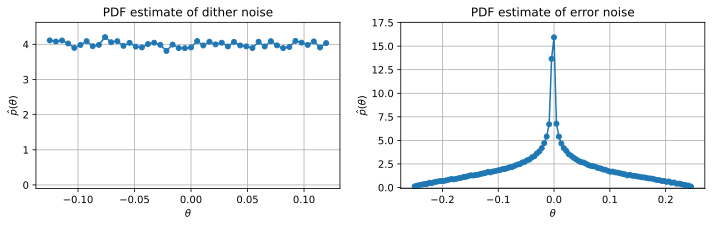

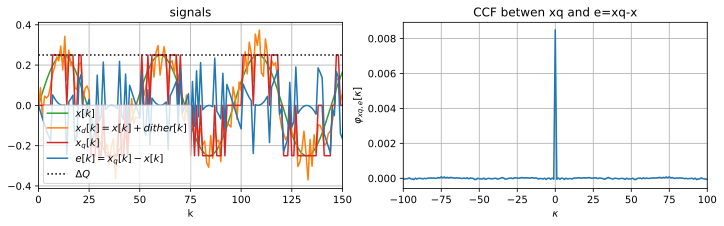

In [30]:
# uniform dither with max amplitude of deltaQ/2
np.random.seed(1)
dither_uni = (np.random.rand(N) - 0.5) * 2 * deltaQ/2

check_dithering(x=x, dither=dither_uni, Q=Q, case='unidither')

**Be careful! Do not harm your ears!**

| Signal            | Audio Player  |
| ----------------- | :------------ |
| $x[k]$            | <audio type="audio/wave" src="x_unidither.wav" controls></audio> |
| $x_d[k]$          | <audio type="audio/wave" src="xd_unidither.wav" controls></audio> |
| $x_q[k]$          | <audio type="audio/wave" src="xq_unidither.wav" controls></audio> |
| $e[k]$            | <audio type="audio/wave" src="e_unidither.wav" controls></audio> |

### Triangular PDF Dither Noise

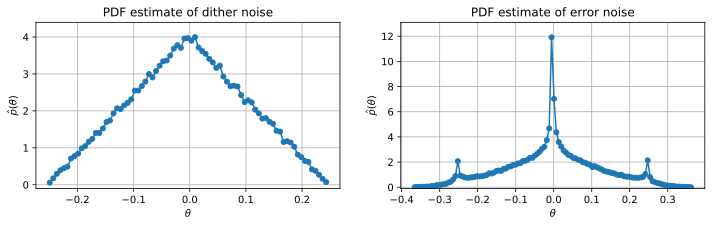

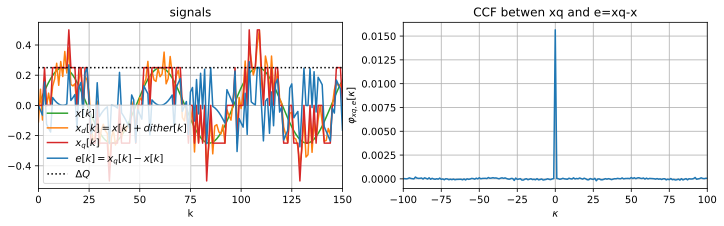

In [31]:
np.random.seed(1)
# uniform PDF for amplitudes -1...+1:
dither_uni1 = (np.random.rand(N) - 0.5) * 2
dither_uni2 = (np.random.rand(N) - 0.5) * 2
# triangular PDF with max amplitude of deltaQ
dither_tri = (dither_uni1 + dither_uni2) * deltaQ/2

check_dithering(x=x, dither=dither_tri, Q=Q, case='tridither')

**Be careful! Do not harm your ears!**

| Signal            | Audio Player  |
| ----------------- | :------------ |
| $x[k]$            | <audio type="audio/wave" src="x_tridither.wav" controls></audio> |
| $x_d[k]$          | <audio type="audio/wave" src="xd_tridither.wav" controls></audio> |
| $x_q[k]$          | <audio type="audio/wave" src="xq_tridither.wav" controls></audio> |
| $e[k]$            | <audio type="audio/wave" src="e_tridither.wav" controls></audio> |

# **Copyright**

The notebooks are provided as [Open Educational Resources](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use the notebooks for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Frank Schultz, Digital Signal Processing - A Tutorial Featuring Computational Examples* with the URL https://github.com/spatialaudio/digital-signal-processing-exercises